In [1]:
    !pip install wandb

# Аннотация. В данном ноутбуке реализована сегментация изображений нервных клеток из Kaggle Sartorius - Cell Instance Segmentation.
# В отличае от оригинального соревнования также дополнительно добавлено предсказание типа(класса) клеток.
# Архитектура модифицированный Unet (c измененной функцией активации, добавлением Dropout и Linear слоев для класификации клеток UnetWithCellType (20 эпох)). Логирование wandb(закомментировано).Формирование submisson.csv соревнования и отрисовка результатов в произвольных цветах. 
# Также реализована вторая модель с transfer learning UnetWithResNet (resnet101). Так как предобученные 3х канальные(RGB) модели обучены на цветных картинках, то в случаях картинок градации серого они, в целом, справляются так же как специально обученные на градациях серого модели, но за большее число эпох(40 эпох). UNetWithResNet замораживает базовую модель ResNet101 и модифицирует ее слои для обработки монохромных данных, после этого происходит дообучение модели на монохромных изображениях с использованием модифицированных слоев и дополнительных слоев. 
# Боков Михаил Михайлович

Train Loss ~ 0.18-0.2, Valid Loss: 0.13-0.15,Accuracy_Score: 92-96%, Cell Type Accuracy: 95-98%,Precision:75-77% IOU:~0.5-0.6, F1(Dice) ~0.7-0.8 (в зависимотсти от learning rate, momentum и расположения dropout слоев)

# bokov.mike@gmail.com


In [34]:
import os
os.environ["TORCH_USE_CUDA_DSA"] = "1"
import wandb # для Логирования
import gc
import cv2,PIL # работа с изображениями
import pandas as  pd
import numpy as np
import random
from pathlib import Path
import time # Для времени обучения
from tqdm import * #Для бар'а прохождения эпохи

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # для оптимизаторов
from torchvision import datasets # для данных
import torchvision.models as models # для предобученной модели ResNet
import torchvision.transforms as transforms

import albumentations as A #Агументации
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset # Для создания трансформированного train датасета
from sklearn.metrics import accuracy_score,f1_score #Метрика

import matplotlib.pyplot as plt

In [35]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

In [36]:
class CFG:

# Задаем Конфигурацию

    api = ""# вписать свой API Wandb  
    project = "Cells-Segmentation"# 
    entity = "michaelbokov"# ввести свой логин
    num_epochs = 19 # количество эпох
    train_batch_size = 8 # размер батча обучающей выборки
    test_batch_size = 512 # размер батча тестовой выборки
    num_workers = 2 # количество активных процессов на загрузку данных
    lr = 0.00875 # learning_rate
    seed = 2022 # для функции воспроизводимости

    wandb = True # флаг использования Wandb
    TRAIN_CSV = '../input/sartorius-cell-instance-segmentation/train.csv'
    TRAIN_DIR = '../input/sartorius-cell-instance-segmentation/train/'
    TEST_DIR = '../input/sartorius-cell-instance-segmentation/test/'
    MOMENTUM = 0.850

    WEIGHT_DECAY = 0.0001 

In [37]:
def CFG2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

In [38]:
print(CFG2dict(CFG))

{'MOMENTUM': 0.85, 'TEST_DIR': '../input/sartorius-cell-instance-segmentation/test/', 'TRAIN_CSV': '../input/sartorius-cell-instance-segmentation/train.csv', 'TRAIN_DIR': '../input/sartorius-cell-instance-segmentation/train/', 'WEIGHT_DECAY': 0.0001, 'api': '', 'entity': 'michaelbokov', 'lr': 0.00875, 'num_epochs': 19, 'num_workers': 2, 'project': 'Cells-Segmentation', 'seed': 2022, 'test_batch_size': 512, 'train_batch_size': 8, 'wandb': True}


# **EDA**

In [39]:
df = pd.read_csv(CFG.TRAIN_CSV,sep=',')
df.head()

id                                         annotation  width  \
0  0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1  0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2  0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   
3  0030fd0e6378  196723 4 197427 6 198130 7 198834 8 199538 8 2...    704   
4  0030fd0e6378  167818 3 168522 5 169225 7 169928 8 170632 9 1...    704   

   height cell_type plate_time sample_date  \
0     520    shsy5y  11h30m00s  2019-06-16   
1     520    shsy5y  11h30m00s  2019-06-16   
2     520    shsy5y  11h30m00s  2019-06-16   
3     520    shsy5y  11h30m00s  2019-06-16   
4     520    shsy5y  11h30m00s  2019-06-16   

                            sample_id elapsed_timedelta  
0  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
2  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
3  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
4  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00

100%|██████████| 606/606 [00:05<00:00, 108.73it/s]


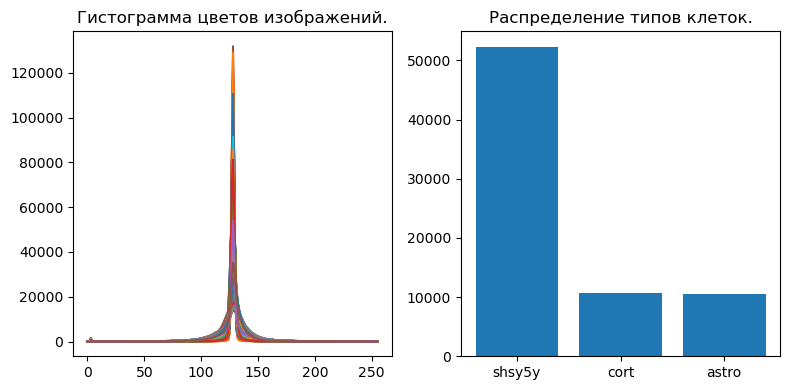

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

#
img_names = Path(CFG.TRAIN_DIR).glob('*')
pbar = tqdm(img_names, total=df.id.unique().shape[0])
for img_name in pbar:
    img = cv2.imread(img_name.as_posix())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    axs[0].plot(hist)
# График распределения классов клеток
cell_class = df['cell_type'].value_counts()
axs[1].bar(cell_class.index, cell_class.values)
axs[0].set_title('Гистограмма цветов изображений.')
axs[1].set_title('Распределение типов клеток.')
# Уменьшение размеров графиков
plt.tight_layout()
plt.show()

**Таким образом видно что по цветам выбросов нет, то есть нет порченных, неполных изображений, "битых пикселей". Так же виден сильный дисбаланс в классах. Закодируем классы.**

In [41]:
df = pd.read_csv(CFG.TRAIN_CSV,sep=',')
Cell_type_encoding={'shsy5y':0,"astro":1,"cort":2}
df['cell_type']=df['cell_type'].map(Cell_type_encoding)
df['cell_type'] = df['cell_type'].astype(int)
df.head()

id                                         annotation  width  \
0  0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1  0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2  0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   
3  0030fd0e6378  196723 4 197427 6 198130 7 198834 8 199538 8 2...    704   
4  0030fd0e6378  167818 3 168522 5 169225 7 169928 8 170632 9 1...    704   

   height  cell_type plate_time sample_date  \
0     520          0  11h30m00s  2019-06-16   
1     520          0  11h30m00s  2019-06-16   
2     520          0  11h30m00s  2019-06-16   
3     520          0  11h30m00s  2019-06-16   
4     520          0  11h30m00s  2019-06-16   

                            sample_id elapsed_timedelta  
0  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
2  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
3  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
4  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00

**Аннотации (annotations) представляют собой информацию о масках каждой отдельной клетки на изображении закодированных методом RLE. Маска обычно представлена в виде сегментов, где каждый сегмент представляет одну клетку. У некоторых изображений маска разделена на много частей в строках датасета.**

**RLE (Run-Length Encoding) представляет собой способ кодирования маски, где последовательность значений используется для описания длины подряд идущих пикселей.В данном случае пары чисел(начальной позиции пикселя и количества).**


In [43]:
def rle_decode(mask_rle, shape):
    '''
    Функция принимает RLE-кодированную маску и размеры исходного изображения, и возвращает декодированную бинарную маску (массив NumPy).
    mask_rle: RLE-кодированная маска в виде строки
    shape : размеры исходного изображения передается как пара (высота, ширина).
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

**Функция для произвольного задания цветов маски по каналам RGB**

In [44]:
def create_mask_image(binary_mask):
    '''
    Создание маски изображения в произвольных цветах (трансформация пары 0,1 по каналам в настраиваемые цвета)
    binary_mask: бинарная маска (массив NumPy)
    '''
    mask_image = np.zeros((binary_mask.shape[0], binary_mask.shape[1], 3), dtype=np.uint8)
    mask_image[..., 0] = binary_mask * 222  # Красный канал
    mask_image[..., 1] = binary_mask * 155  # Зеленый канал
    mask_image[..., 2] = binary_mask * 100  # Синий канал
    mask_image[np.where(binary_mask == 0)] = [0, 125, 255] 
    return mask_image

In [45]:
def draw_trio (img_id):
    '''
    Отрисовка оригинального изображения, маски и наложения в ряд.
    '''
   
   
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.imread(CFG.TRAIN_DIR + img_id + '.png'))
    plt.axis("off")
    plt.title(f'Оригинал Изображения: {img_id}')

   
    plt.subplot(1, 3, 2)
    mask_rle = df[df.id == img_id]['annotation'].str.cat(sep=' ')
    mask = create_mask_image(rle_decode(mask_rle,(520, 704)))
    
    plt.imshow(mask)
    plt.axis("off")
    plt.title(f'Маска Изображения: {img_id}')
    
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.imread(CFG.TRAIN_DIR + img_id + '.png'))
    plt.imshow(mask, alpha=0.2)
    plt.axis("off")
    plt.title(f'Наложение: {img_id}')

    plt.tight_layout()
    plt.show()

Сгруппируем исходный датасет по названиям изображений.

In [46]:
df_g = df.copy()
df_g['annotation'] = 1
df_g = df_g.groupby(['id', 'width', 'height', 'cell_type']).count().reset_index()
df_groupby = df_g[['id','annotation', 'width', 'height', 'cell_type']]
df_groupby.head()


id  annotation  width  height  cell_type
0  0030fd0e6378         395    704     520          0
1  0140b3c8f445         108    704     520          1
2  01ae5a43a2ab          36    704     520          2
3  026b3c2c4b32          42    704     520          2
4  029e5b3b89c7          34    704     520          2

**При каждом запуске открисуем, что бы не повторяться, произвольные 3 тройки клеток (исходное изображение, заданная маска,наложение).**

In [47]:
def get_random_id_by_type(df, type_value):
    '''
    Функция берет произвольный id картинки по переданному типу клетки
    '''
    group = df[df['cell_type'] == type_value]
    random_id = group['id'].sample(n=1).values[0]
    return random_id

# **Отрисовка**

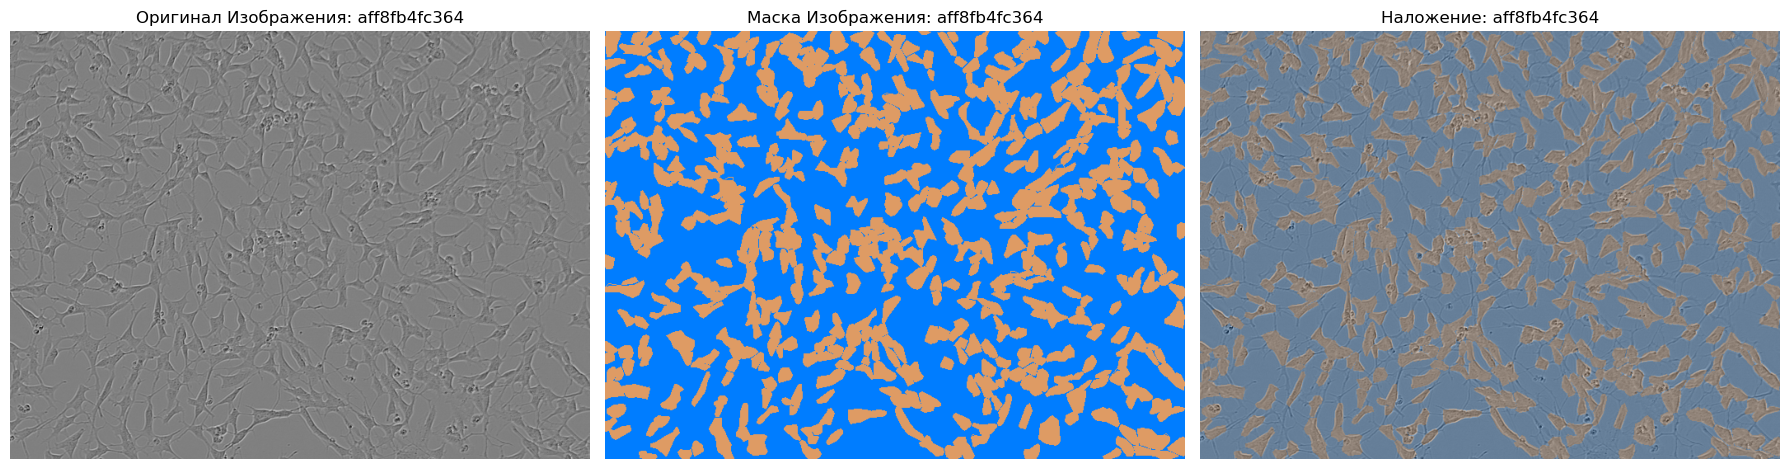

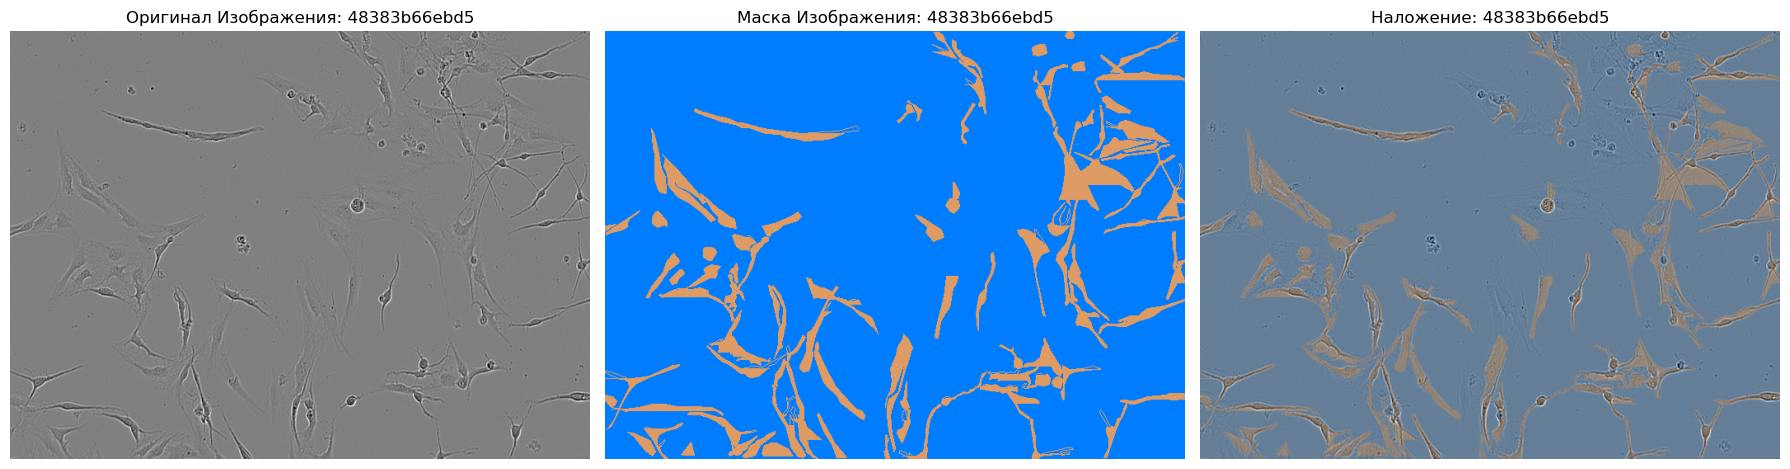

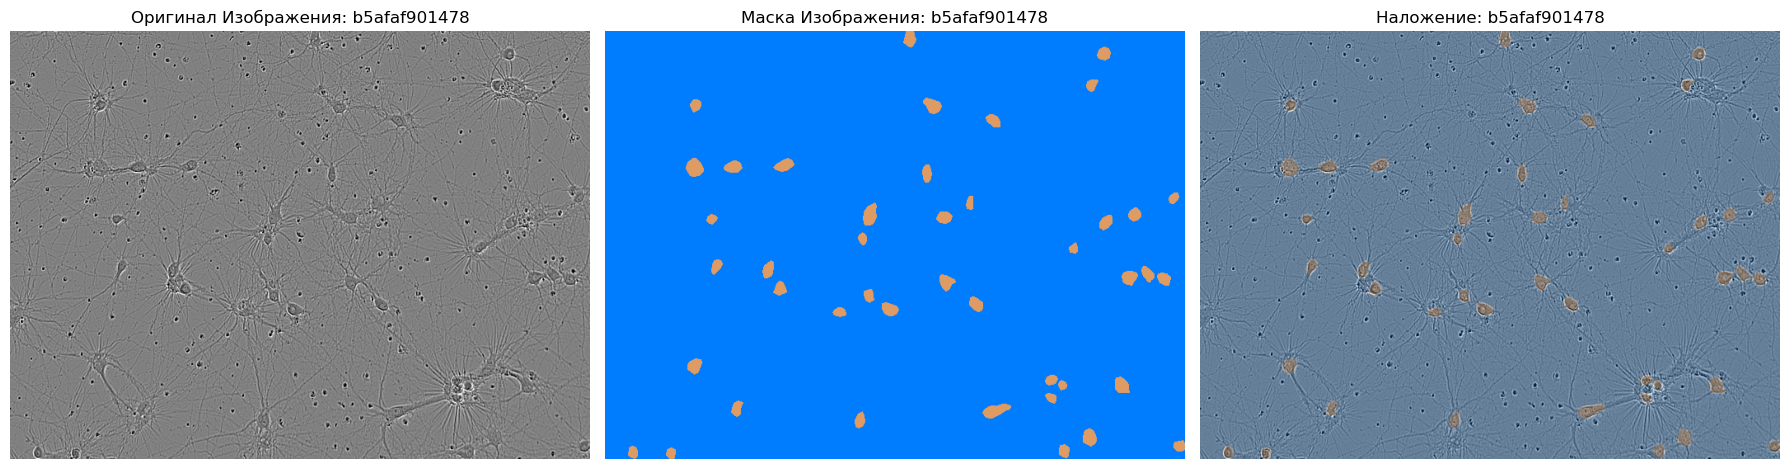

In [49]:
cell_types_unique=df_groupby['cell_type'].unique()#.astype(str)
for cell_t in cell_types_unique:
    img_id=get_random_id_by_type(df,cell_t)
    draw_trio(img_id)

# **Preprocessing**

**Классы функций.
*1) Класс трансформаций(агументаций). Происходят трансформации(изменение размеров, отображение,транспонирование) train части, однако для корректной оценки модели, для valid части также нужно произвести изменение размеров изображений.\
**2) Класс для создания тренировочных и валидационных датасетов на основе изображений для передачи в PyTorch Dataloader. Содержит изображение, маску, код типа клетки.\**
**3) Класс модернизированной архитектуры UNet.**

In [50]:
class DataTransforms:
    '''
    Класс агументаций
    '''
    @staticmethod
    def transform_train():
        transforms = [
            A.Resize(256, 256, p=1),  # Изменение размера
            A.HorizontalFlip(p=0.5),  # Отображение
            A.Transpose(p=0.5),       # Транспонирование  
            A.Rotate(limit=45, p=0.5),# Повороты на угол до 45 градусов
            ToTensorV2(p=1)
        ]
        return A.Compose(transforms)

    @staticmethod
    def transform_valid():
        transforms = [
            A.Resize(256, 256, p=1),
            ToTensorV2(p=1)
        ]
        return A.Compose(transforms)

In [51]:
class CellDataset(Dataset):
    def __init__(self, ids, df, image_dir, transforms=None, status='train',resnet=False):
        super().__init__()
        self.ids = ids
        self.df = df
        self.image_dir = image_dir
        self.transforms = transforms
        self.status = status
        self.resnet = resnet

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        img_id = self.ids[index]

        # Загрузка изображения
        img_path = os.path.join(self.image_dir, img_id + ".png")
        img_bgr = cv2.imread(img_path) #читаем в numpay массив BGR
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # -> RGB
        img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY) # -> В оттенки серого, уменьшая число каналов с 3 до 1 и нормализуем
        if self.resnet==False:
            img = np.array(img).astype(np.float32)
            img /= 255.0
            
        else:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = np.array(img_rgb).astype(np.float32)
            img /= 255.0 
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img -= mean  # Вычитание среднего значения
            img /= std  # Деление на стандартное отклонение
       
        if self.status == 'train':  # При обучении возвращает набор (изображение,маска,идентификатор-название изображения,тип клетов)
            # Загрузка маски
            mask_rle = self.df[self.df["id"] == img_id]['annotation'].str.cat(sep=' ')
            mask = rle_decode(mask_rle, (520, 704)) # Декодирование маски 
            mask = np.array(mask).astype(np.float32)

            # Загрузка типа клетки (0,1,2)
            cell_type = self.df[self.df["id"] == img_id]["cell_type"].values[0]

            # Применение агументаций
            if self.transforms is not None:
                augmented = self.transforms(image=img, mask=mask)
                img = augmented["image"]
                mask = augmented["mask"]
                
            return img, mask,img_id,cell_type
        else:
            if self.transforms is not None:
                img = self.transforms(image=img)["image"]
            return img, img_id

**Архитектура U-Net состоит из энкодера (downsampling path) и декодера (upsampling path). Они объединяются в единую модель, где происходит передача информации между ними. 

Энкодер (Downsampling Path): Этот слой отвечает за постепенное уменьшение размера изображения и извлечение признаков более высокого уровня. Он состоит из повторяющихся блоков, включающих сверточные слои, функции активации и операцию пулинга. Каждый блок уменьшает размер изображения и увеличивает количество признаков.

Декодер (Upsampling Path): Этот слой отвечает за восстановление пространственного разрешения изображения и восстановление деталей. Он состоит из повторяющихся блоков, включающих операцию транспонированной свертки (например, ConvTranspose2d), сверточные слои, функции активации и операции объединения (например, конкатенация). Каждый блок увеличивает размер изображения и уменьшает количество признаков, используя информацию из энкодера. Поэтому в декодере обычно выполняется конкатенация или объединение данных из соответствующих слоев энкодера и текущего слоя декодера.

Обычно в UNet используются слои  функции активации (ReLU), операций пулинга (MaxPooling),транспонированной свертки (ConvTranspose2d).

В данной архитектуре заменена функция активации (SELU), добавлены промежуточные сверточные слои,линейные слои, и слои дропаута.**



In [53]:
class ConvBlock(nn.Module):
    '''
    Сверточные слои c батч-нормализацией и активацией
    '''
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation1 = nn.SELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.activation2 = nn.SELU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation2(x)
        return x
class EncoderBlock_main(nn.Module):
    ''''
    Энкодер
    1) Пулинг
    2) Свертка
    3) Батч-нормализация
    4) Активация
    '''
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock_main, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation1 = nn.SELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.activation2 = nn.SELU()

    def forward(self, x):
        x = self.pool(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation2(x)
        return x

class CellTypeEncoder(nn.Module):
    '''
    Линейные слои для определения типа клетки
    '''
    def __init__(self, in_features, num_classes,dropout=True):
        super(CellTypeEncoder, self).__init__()

        hidden_size1 = 512
        hidden_size2 = 256
        hidden_size3 = 128
        hidden_size4 = 64
        
        self.fc1 = nn.Linear(in_features, hidden_size1)
        #self.dropout1 = nn.Dropout(p=0.2) 
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        #self.dropout1 = nn.Dropout(p=0.2) 
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.dropout1 = nn.Dropout(p=0.2) 
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, num_classes)
        self.selu = nn.SELU()
    def forward(self, x):
        x = self.selu(self.fc1(x))
        #x = self.dropout1(x)
        x = self.selu(self.fc2(x))
        x = self.dropout1(x)
        x = self.selu(self.fc3(x))
        #x = self.dropout1(x)
        x = self.selu(self.fc4(x))
        #x = self.dropout1(x)
        x = self.fc5(x)
        return x

class UNetWithCellType(nn.Module):
    '''
    1)Входные слои сверток с нормализацией и активацией
    2)Слои сверток, Пулинга, Дропаутов
    3)Слои транспонированной свертки и последующие сверточные слои с нормализацией и активациями
    4)Линейные слои для определения типа клеток
    5)Выходные слои отдельно для масок и вероятностей типов клетки
    '''
    def __init__(self, in_channels=1, out_channels=1, num_classes=3, encoder_cell_features=1024,dropout=True):
        super(UNetWithCellType, self).__init__()
        self.encoder1 = ConvBlock(in_channels,64)
        #self.dropout1 = nn.Dropout(p=0.2)
        self.encoder2 = EncoderBlock_main(64, 128)
        #self.dropout1 = nn.Dropout(p=0.2)
        self.encoder3 = EncoderBlock_main(128, 256)
        self.encoder4 = EncoderBlock_main(256, 512)
        #self.dropout2 = nn.Dropout(p=0.2)
        self.encoder5 = EncoderBlock_main(512, 1024)
        self.dropout2 = nn.Dropout(p=0.2)
        self.decoder4 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2, stride=2)
        self.decoder4_1 = ConvBlock(1024, 512)
        #self.dropout3 = nn.Dropout(p=0.2)
        self.decoder3 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2, stride=2)
        self.decoder3_1 = ConvBlock(512, 256)
        #self.dropout3 = nn.Dropout(p=0.2)
        self.decoder2 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2, stride=2)
        
        self.decoder2_1 = ConvBlock(256, 128)
        self.decoder1 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2, stride=2)
        
        self.decoder1_1 = ConvBlock(128, 64)
        self.dropout3 = nn.Dropout(p=0.2)
        self.mask_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.cell_type_encoder = CellTypeEncoder(encoder_cell_features, num_classes,dropout=True)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        #enc1 = self.dropout1(enc1)
        enc2 = self.encoder2(enc1)
        #enc2 = self.dropout2(enc2)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        #enc4 = self.dropout2(enc4)
        enc5 = self.encoder5(enc4)
        enc5 = self.dropout2(enc5)
        dec4 = self.decoder4(enc5)
        dec4_1 = self.decoder4_1(torch.cat([enc4, dec4], 1))
        #dec4_1 = self.dropout2(dec4_1)
        dec3 = self.decoder3(dec4_1)
        dec3_1 = self.decoder3_1(torch.cat([enc3, dec3], 1))
        #dec3_1 = self.dropout3(dec3_1)
        dec2 = self.decoder2(dec3_1)
        dec2_1 = self.decoder2_1(torch.cat([enc2, dec2], 1))
        dec1 = self.decoder1(dec2_1)
        #dec1 = self.dropout3(dec1)
        dec1_1 = self.decoder1_1(torch.cat([enc1, dec1], 1))
        dec1_1 = self.dropout3(dec1_1)
        mask_output = self.mask_conv(dec1_1)
        cell_type_features = torch.mean(enc5, dim=(2, 3))  # Извлечение признаков для классификации типов клеток
        cell_type_output = self.cell_type_encoder(cell_type_features)
        mask_output = self.sigmoid(mask_output)
        cell_type_output = self.softmax(cell_type_output)
        return mask_output, cell_type_output

**Подготовка обучения. Создание train и valid загрузчиков.**


In [54]:
def train_and_valid_dataloaders(df, train_ids, val_ids,resnet=False):
    '''
    Создание тренировочных и валидационых PyTorch загрузчиков пакетов данных.
    '''
    trn = df_groupby[df_groupby['id'].isin(train_ids)].reset_index(drop=True)
    val = df_groupby[df_groupby['id'].isin(val_ids)].reset_index(drop=True)
    
    
    train_dataset = CellDataset(trn["id"].to_numpy(),df,CFG.TRAIN_DIR,transforms=DataTransforms.transform_train(),resnet=resnet)
    valid_dataset = CellDataset(val["id"].to_numpy(),df,CFG.TRAIN_DIR,transforms=DataTransforms.transform_valid(),resnet=resnet)
  
    
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=CFG.train_batch_size,num_workers=CFG.num_workers,shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=CFG.train_batch_size,num_workers=CFG.num_workers,shuffle=False)
           
    return train_loader, valid_loader


In [56]:
def iou_calc(predicted_mask, true_mask):
    predicted_mask = predicted_mask.cpu().numpy()
    true_mask = true_mask.cpu().numpy()
    intersection = np.logical_and(predicted_mask, true_mask)
    union = np.logical_or(predicted_mask, true_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [55]:
def precisionscore(true_masks, predicted_masks):
    true_positives = 0
    false_positives = 0
    
    for true, pred in zip(true_masks, predicted_masks):
        if pred == 1 and true == 1:
            true_positives += 1
        elif pred == 1 and true == 0:
            false_positives += 1
    
    if true_positives + false_positives > 0:
        precision_score = true_positives / (true_positives + false_positives)
    else:
        precision_score = 0.0
    
    return precision_score



Для подсчета точности мы также используем бинарные предсказанные сегменты predicted_segments,сравнивая их с истинными масками masks.
Затем мы вычисляем общее количество пикселей total и количество правильно предсказанных пикселей correct, чтобы вычислить точность.
Или мы создаем два списка predicted_masks и true_masks, в которые добавляем предсказанные и истинные маски соответственно. 
Затем мы используем accuracy_score(true_masks, predicted_masks) для вычисления точности и умножаем результат на 100 для получения 
процентного значения.


In [57]:
def train(model,train_loader, valid_loader, num_epochs, lr):#,wandb=True):
    #wandb.login(key=CFG.api)
    os.environ["TORCH_USE_CUDA_DSA"] = "1"
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
    #if CFG.wandb:
        #os.environ["WANDB_API_KEY"] = ""#CFG.api
        #wandb.login(key=CFG.api)#wandb_api)
     #   wandb.init(project=CFG.project, entity=CFG.entity, reinit=True,config=CFG2dict(CFG))
      #  wandb.watch(model, log='all')
    seed= seed_everything(CFG.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
   # print(model)
    criterion_cell_type = nn.CrossEntropyLoss().to(device)
    criterion = nn.BCELoss().to(device)  # Бинарная кросс-энтропия
    optimizer = torch.optim.SGD(model.parameters(), weight_decay=CFG.WEIGHT_DECAY, lr = lr, momentum=CFG.MOMENTUM)
    #if CFG.wandb:
     #   wandb.watch(model, log='all') # логируем все (метрики, лоссы, градиенты)
      # For Visualization
    train_loss_list = []
    valid_loss_list = []
    cell_type_accuracy_list=[]
    iou_scores_list = []
    f1_scores_list = []
   
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        start_time = time.time() 
        model.train()  # Устанавливаем модель в режим обучения
        train_loss = 0.0
        total_iou = 0.0
        total_f1 = 0.0
        num_samples = 0
        for images, masks,i,cell_type in train_loader:
            images = images.to(device).float()
            masks = masks.to(device).float()
            cell_type = cell_type.to(device)
            masks = masks.view(images.shape[0], -1, 256, 256)
           
            optimizer.zero_grad()
            # Прямой проход
            outputs, predicted_cell_type = model(images) 
            loss_mask = criterion(outputs, masks) #Лосс масок
            loss_cell_type=criterion_cell_type(predicted_cell_type,cell_type) #Лосс типов клеток
            # Обратный проход
            loss=0.9*loss_mask+0.1*loss_cell_type  # Лосс модели с весами по функциям потерь масок и типов клеток
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
        train_loss /= len(train_loader.dataset)
        # Валидация
        model.eval()  # Устанавливаем модель в режим оценки 
        valid_loss = 0.0
        correct = 0
        total = 0
        predicted_masks = []
        predicted_cell_types = []
        true_masks = []
        true_cell_types = []
        #correct_cell_types = 0
        #total_cell_types = 0
        with torch.no_grad():
            for images, masks,i,cell_type in valid_loader:
                images, masks = images.to(device).float(),masks.to(device).float()
                cell_type = cell_type.to(device).float() 
                                               
                outputs, predicted_cell_type = model(images) # Предсказанные маски(вероятностные значения для каждого пикселя или пиксельного канала.)
                                                             #и типы клеток(тензоры)
                               
                masks = masks.view(images.shape[0], -1, 256, 256)
                loss = criterion(outputs, masks)
                valid_loss += loss.item() * images.size(0)
                     
                predicted_segments = (outputs > 0.5).float() #Преобразования предсказанных сегментов (outputs) в бинарные значения 0 и 1. 
                                                            #Пороговое значение 0.5.  Пиксель фон(0), объект (1).
                iou = iou_calc(predicted_segments, masks)  
                f1 = f1_score(predicted_segments.view(-1).cpu().numpy(), masks.view(-1).cpu().numpy())
                total_iou += iou * images.size(0)
                total_f1 += f1 * images.size(0)
                num_samples += images.size(0)
                                
                predicted_masks.extend(predicted_segments.view(-1).tolist())# Список предсказанных масок
                true_masks.extend(masks.view(-1).tolist()) # Список известных масок
                predicted_cell = torch.max(predicted_cell_type, dim=1) # Так как три класса клеток, то для каждого image из батча выбор максимальной вероятности(класса).
                
                predicted_cell_types.extend(predicted_cell)  # Список предсказанных cell_type
                true_cell_types.extend(cell_type.view(-1).tolist())  # Список истинных значения cell_type
             
                accuracy = (predicted_segments == masks).float().mean() * 100 #Ручной расчет точности
                total += masks.view(-1).size(0) #Ручной расчет точности.Увеличение переменной total на количество образцов в текущем батче. Что бы получить итоговое количество наборов 
                correct += (predicted_segments == masks).sum().item() #Ручной расчет точности.
               
            valid_loss /= len(valid_loader.dataset)
            
            accuracy = correct / total * 100 # Ручной расчет Accuracy
            accuracyscore = accuracy_score(true_masks, predicted_masks) * 100
                  
            #correct_cell_types = 0
            #total_cell_types = 0
            predicted_cell_types = [tensor.tolist() for tensor in predicted_cell_types] # Список вероятностных тензоров в список
            result_ = []
            result_ = [sublist for sublist in predicted_cell_types[1::2]]  # Вырезаем вероятности и оставляем подсписки номеров классов
            result = [item for sublist in result_ for item in sublist] # Убираем подсписки в один список предсказанных классов
            predicted_cell_types=result
            predicted_cell_types = np.array(predicted_cell_types)
           
            cell_type_accuracy = accuracy_score(true_cell_types, predicted_cell_types) * 100 #Поэлементное вычисление точности совпадения 2х списков
            
            precision=precisionscore(true_masks, predicted_masks)*100
            #-классов поступивших изображений и предсказанных классов
            epoch_f1 = total_f1 / num_samples
            epoch_iou = total_iou / num_samples 
            iou_scores_list.append(epoch_iou)
            f1_scores_list.append(epoch_f1)
        
        end_time = time.time()  # Записываем время окончания эпохи
        epoch_time = end_time - start_time  # Вычисляем время прохождения эпохи
     
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Accuracy_Manualy: {accuracy:.2f}%,Accuracy_Score: {accuracyscore:.2f}%,Cell Type Accuracy: {cell_type_accuracy:.2f}%,IoU: {epoch_iou:.2f},Precision:{precision:.2f},F1: {epoch_f1:.2f},Time: {epoch_time:.2f} seconds")
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        cell_type_accuracy_list.append(cell_type_accuracy/100)
        #f1_scores_list.append(f1)
   
        #del model, optimizer, train_loader, valid_loader, train_losses, valid_losses
        #if wandb:
        #    wandb.log({'Train_loss': train_loss,
         #              'Valid Loss': valid_loss,
         #              'Accuracy': accuracyScore,
         #              'Precision': precision})
   # gc.collect()
    #wandb.finish()
    plt.plot(range(1, num_epochs+1), train_loss_list,c='blue', label='Train Loss')
    plt.plot(range(1, num_epochs+1), valid_loss_list,c='cyan', label='Valid Loss')
    plt.plot(range(1, num_epochs+1), cell_type_accuracy_list,c='green', label='Cell type accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    plt.show()
    gc.collect()
    torch.cuda.empty_cache()
    
    print(f" Summary Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f},Accuracy_Score: {accuracyscore:.2f}%,Cell Type Accuracy: {cell_type_accuracy:.2f}%,Precision:{precision:.2f},IoU: {epoch_iou:.2f},F1: {epoch_f1:.2f}")

# **Обучение**

Epochs:   5%|▌         | 1/19 [00:31<09:21, 31.20s/it]

Epoch [1/19], Train Loss: 0.5620, Valid Loss: 0.3366, Accuracy_Manualy: 90.09%,Accuracy_Score: 90.09%,Cell Type Accuracy: 50.00%,IoU: 0.25,Precision:57.36,F1: 0.39,Time: 31.20 seconds


Epochs:  11%|█         | 2/19 [01:03<08:58, 31.67s/it]

Epoch [2/19], Train Loss: 0.3626, Valid Loss: 0.2874, Accuracy_Manualy: 91.24%,Accuracy_Score: 91.24%,Cell Type Accuracy: 68.03%,IoU: 0.37,Precision:61.74,F1: 0.54,Time: 32.00 seconds


Epochs:  16%|█▌        | 3/19 [01:34<08:26, 31.66s/it]

Epoch [3/19], Train Loss: 0.2931, Valid Loss: 0.2172, Accuracy_Manualy: 92.35%,Accuracy_Score: 92.35%,Cell Type Accuracy: 95.90%,IoU: 0.38,Precision:74.53,F1: 0.55,Time: 31.65 seconds


Epochs:  21%|██        | 4/19 [02:06<07:55, 31.68s/it]

Epoch [4/19], Train Loss: 0.2651, Valid Loss: 0.1810, Accuracy_Manualy: 92.56%,Accuracy_Score: 92.56%,Cell Type Accuracy: 95.08%,IoU: 0.39,Precision:78.04,F1: 0.55,Time: 31.70 seconds


Epochs:  26%|██▋       | 5/19 [02:38<07:24, 31.76s/it]

Epoch [5/19], Train Loss: 0.2511, Valid Loss: 0.2419, Accuracy_Manualy: 92.02%,Accuracy_Score: 92.02%,Cell Type Accuracy: 81.15%,IoU: 0.44,Precision:63.39,F1: 0.61,Time: 31.90 seconds


Epochs:  32%|███▏      | 6/19 [03:10<06:54, 31.85s/it]

Epoch [6/19], Train Loss: 0.2565, Valid Loss: 0.1856, Accuracy_Manualy: 92.84%,Accuracy_Score: 92.84%,Cell Type Accuracy: 71.31%,IoU: 0.41,Precision:78.10,F1: 0.58,Time: 32.02 seconds


Epochs:  37%|███▋      | 7/19 [03:42<06:23, 31.97s/it]

Epoch [7/19], Train Loss: 0.2368, Valid Loss: 0.2316, Accuracy_Manualy: 91.28%,Accuracy_Score: 91.28%,Cell Type Accuracy: 74.59%,IoU: 0.45,Precision:58.03,F1: 0.61,Time: 32.23 seconds


Epochs:  42%|████▏     | 8/19 [04:14<05:50, 31.87s/it]

Epoch [8/19], Train Loss: 0.2425, Valid Loss: 0.2614, Accuracy_Manualy: 90.58%,Accuracy_Score: 90.58%,Cell Type Accuracy: 76.23%,IoU: 0.20,Precision:69.18,F1: 0.32,Time: 31.66 seconds


Epochs:  47%|████▋     | 9/19 [04:46<05:19, 31.91s/it]

Epoch [9/19], Train Loss: 0.2379, Valid Loss: 0.1698, Accuracy_Manualy: 93.17%,Accuracy_Score: 93.17%,Cell Type Accuracy: 95.90%,IoU: 0.47,Precision:74.48,F1: 0.63,Time: 32.00 seconds


Epochs:  53%|█████▎    | 10/19 [05:18<04:48, 32.01s/it]

Epoch [10/19], Train Loss: 0.2301, Valid Loss: 0.1581, Accuracy_Manualy: 93.36%,Accuracy_Score: 93.36%,Cell Type Accuracy: 96.72%,IoU: 0.50,Precision:71.55,F1: 0.67,Time: 32.21 seconds


Epochs:  58%|█████▊    | 11/19 [05:50<04:16, 32.09s/it]

Epoch [11/19], Train Loss: 0.2267, Valid Loss: 0.1864, Accuracy_Manualy: 93.10%,Accuracy_Score: 93.10%,Cell Type Accuracy: 54.10%,IoU: 0.47,Precision:73.46,F1: 0.63,Time: 32.26 seconds


Epochs:  63%|██████▎   | 12/19 [06:22<03:44, 32.09s/it]

Epoch [12/19], Train Loss: 0.2231, Valid Loss: 0.1762, Accuracy_Manualy: 92.74%,Accuracy_Score: 92.74%,Cell Type Accuracy: 96.72%,IoU: 0.40,Precision:78.13,F1: 0.57,Time: 32.09 seconds


Epochs:  68%|██████▊   | 13/19 [06:55<03:12, 32.09s/it]

Epoch [13/19], Train Loss: 0.2308, Valid Loss: 0.1642, Accuracy_Manualy: 92.96%,Accuracy_Score: 92.96%,Cell Type Accuracy: 94.26%,IoU: 0.43,Precision:77.25,F1: 0.60,Time: 32.08 seconds


Epochs:  74%|███████▎  | 14/19 [07:27<02:40, 32.09s/it]

Epoch [14/19], Train Loss: 0.2176, Valid Loss: 0.1692, Accuracy_Manualy: 93.22%,Accuracy_Score: 93.22%,Cell Type Accuracy: 96.72%,IoU: 0.48,Precision:72.32,F1: 0.64,Time: 32.08 seconds


Epochs:  79%|███████▉  | 15/19 [07:59<02:08, 32.14s/it]

Epoch [15/19], Train Loss: 0.2230, Valid Loss: 0.2032, Accuracy_Manualy: 92.50%,Accuracy_Score: 92.50%,Cell Type Accuracy: 88.52%,IoU: 0.44,Precision:67.98,F1: 0.61,Time: 32.25 seconds


Epochs:  84%|████████▍ | 16/19 [08:31<01:36, 32.19s/it]

Epoch [16/19], Train Loss: 0.2247, Valid Loss: 0.1632, Accuracy_Manualy: 93.29%,Accuracy_Score: 93.29%,Cell Type Accuracy: 96.72%,IoU: 0.53,Precision:67.67,F1: 0.69,Time: 32.30 seconds


Epochs:  89%|████████▉ | 17/19 [09:03<01:04, 32.22s/it]

Epoch [17/19], Train Loss: 0.2122, Valid Loss: 0.1562, Accuracy_Manualy: 93.43%,Accuracy_Score: 93.43%,Cell Type Accuracy: 91.80%,IoU: 0.50,Precision:73.35,F1: 0.66,Time: 32.28 seconds


Epochs:  95%|█████████▍| 18/19 [09:36<00:32, 32.23s/it]

Epoch [18/19], Train Loss: 0.2191, Valid Loss: 0.1591, Accuracy_Manualy: 93.28%,Accuracy_Score: 93.28%,Cell Type Accuracy: 96.72%,IoU: 0.49,Precision:71.27,F1: 0.66,Time: 32.25 seconds


Epochs: 100%|██████████| 19/19 [10:08<00:00, 32.04s/it]

Epoch [19/19], Train Loss: 0.2117, Valid Loss: 0.1504, Accuracy_Manualy: 93.52%,Accuracy_Score: 93.52%,Cell Type Accuracy: 96.72%,IoU: 0.49,Precision:74.52,F1: 0.66,Time: 32.51 seconds


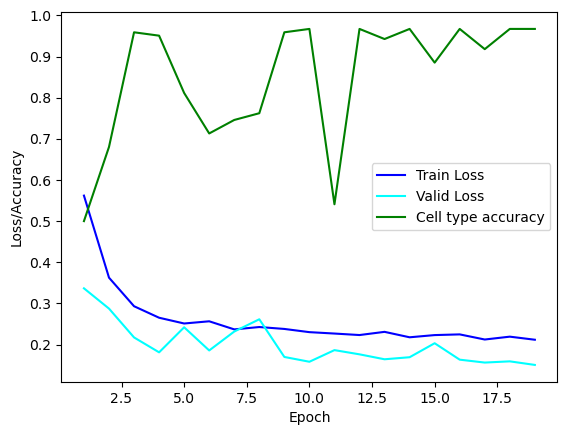

 Summary Train Loss: 0.2117, Valid Loss: 0.1504,Accuracy_Score: 93.52%,Cell Type Accuracy: 96.72%,Precision:74.52,IoU: 0.49,F1: 0.66


In [58]:
#wandb.login(key=")
os.environ["TORCH_USE_CUDA_DSA"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# Создание датасета и загрузчиков
ids = df['id'].unique()
from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(ids, test_size=0.2, random_state=CFG.seed)
train_loader, valid_loader = train_and_valid_dataloaders(df, train_ids, val_ids,resnet=False)

# Создание модели и обучение
model = UNetWithCellType(dropout=True)
#modelRN = UNetWithResNet()
train(model,train_loader, valid_loader, CFG.num_epochs, CFG.lr)#,wandb=True)

# **Сохраним модель**

In [59]:
model_name = f"model_{CFG.num_epochs}_{CFG.train_batch_size}_{CFG.lr}_{CFG.MOMENTUM}_{CFG.WEIGHT_DECAY}.pth"
torch.save(model.state_dict(), model_name)

# **Создание, сохранение submission.csv и отрисовка предскзаний.**


In [60]:
def mask_to_rle(mask):
    '''
    Функция преобразует бинарную маску в RLE-формат.
    '''
    mask_cpu = mask.cpu()  # Копирование тензора на CPU
    pixels = mask_cpu.T.flatten()  # Преобразование маски в одномерный массив
    pixels = np.concatenate([[0], pixels, [0]])  # Добавление фиктивных значений 0 в начало и конец массива
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1  # Определение индексов изменения значений
    runs[1::2] -= runs[:-1:2]  # Вычисление длины повторяющихся сегментов
    rle = ' '.join(str(x) for x in runs)  # Преобразование массива длин сегментов в строку
    return rle

In [61]:
# Создание тестового датасета и загрузчиков

files = os.listdir(CFG.TEST_DIR)
image_ids = np.array([os.path.splitext(file)[0] for file in files])
ids = []
rle_test_preds = []
original_size = (704, 520)  

test_dataset = CellDataset(image_ids,df,CFG.TEST_DIR,transforms=DataTransforms.transform_valid(),status='test',resnet=False)

test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=CFG.train_batch_size,num_workers=CFG.num_workers,shuffle=False)

In [62]:
def test(model, test_loader):
    '''
    Функция получающая предсказанные маски, соответствующие ID и предсказанные типы клеток. Создание итогового submission.csv
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    masks_list = []  # Список для хранения масок и ID
    predicted_rles = []
    with torch.no_grad():
        for images, image_ids in test_loader:
            images = images.to(device).float()

            # Прямой проход
            outputs, predicted_cell_type = model(images)
            masks = (outputs > 0.5).float()  # Применение порога для получения бинарных масок
            
            # Добавление маски, ID и предсказанного типа клетки в список
            for i in range(len(image_ids)):
                masks_list.append((masks[i], image_ids[i], predicted_cell_type[i]))
                predicted_index = torch.argmax(predicted_cell_type[i])
                predicted_class = list(Cell_type_encoding.keys())[predicted_index]
                #print(f"Predicted cell type for {image_ids[i]}: {predicted_class}")
                predicted_rle = mask_to_rle(masks[i])
                predicted_rles.append(predicted_rle)
    df_id_rle = pd.DataFrame({'id': image_ids, 'predicted': predicted_rles})
    df_id_rle.to_csv('submission.csv', index=False)
   
    return masks_list

# **Предсказание и отрисовка резуальтата**

/tmp/ipykernel_28/340758525.py:6: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3571.)
  pixels = mask_cpu.T.flatten()  # Преобразование маски в одномерный массив


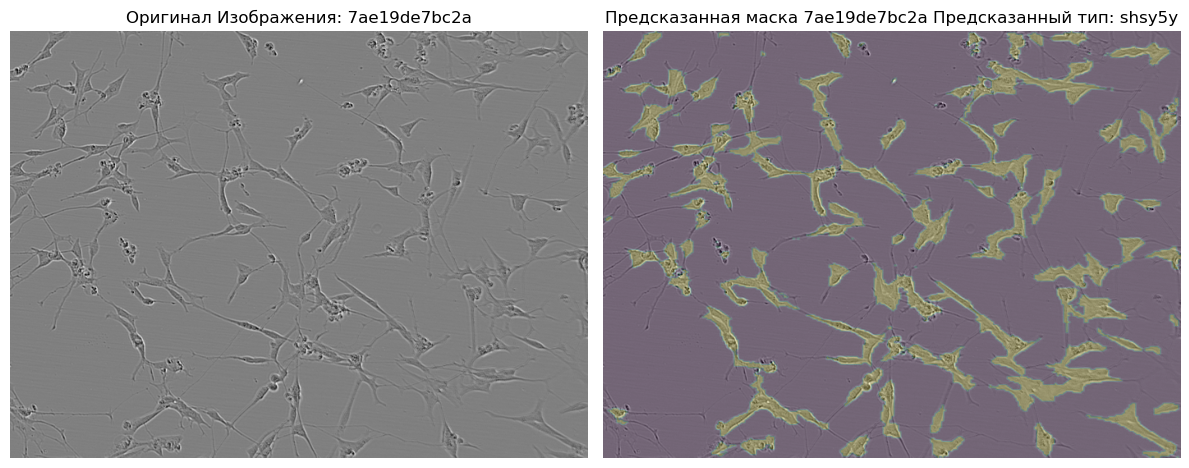

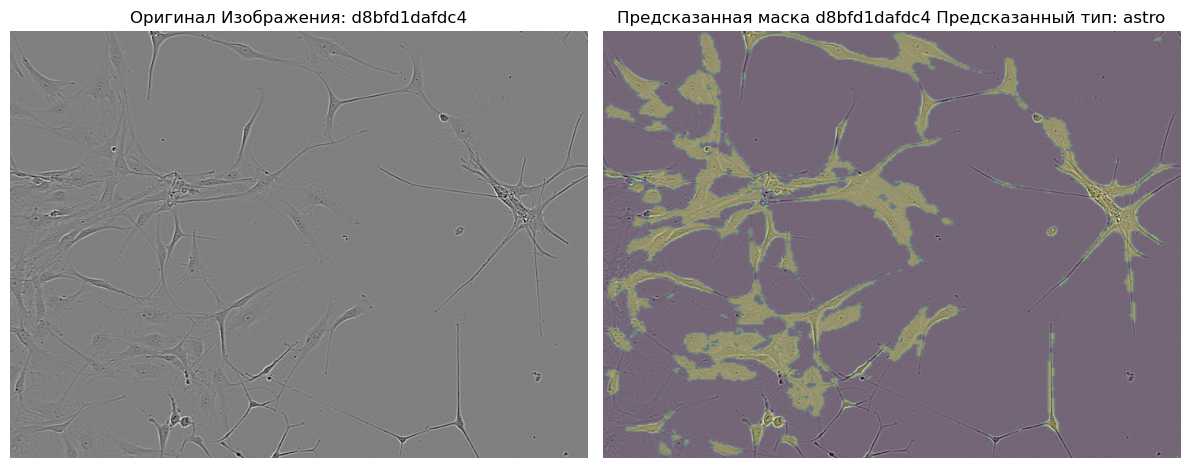

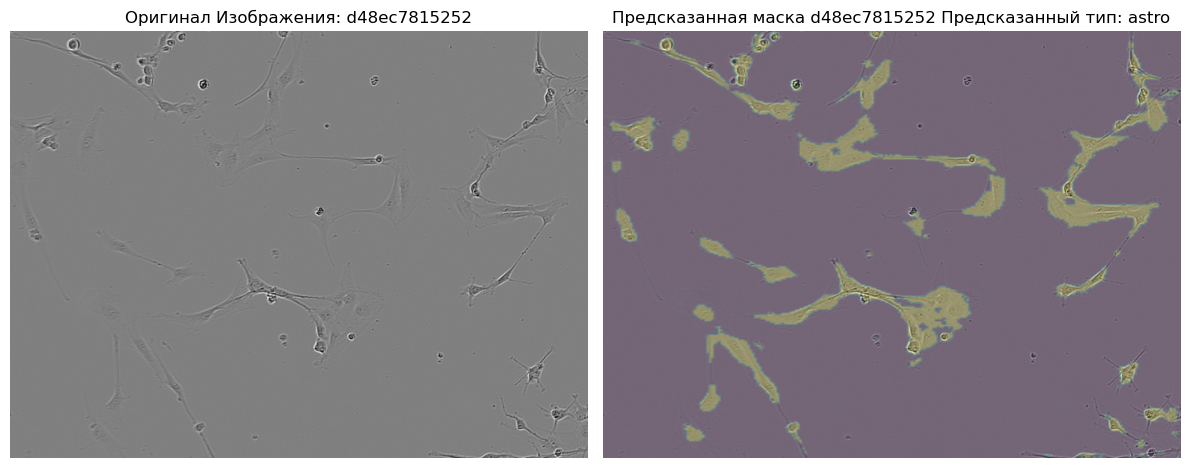

In [63]:
masks_list = test(model, test_loader)

for i, (masks, image_ids, predicted_cell_type) in enumerate(masks_list):
    if masks.numel() == 0:  # Check if masks is empty
        continue
   
    # Преобразование масок в массивы NumPy
    masks = np.squeeze(masks) # Удаление размерности num_classes (если есть)
    masks = masks.cpu().numpy()  # Преобразование в массив NumPy
    full_masks = cv2.resize(masks, original_size)
    predicted_index = torch.argmax(predicted_cell_type, dim=-1)
    predicted_class = list(Cell_type_encoding.keys())[predicted_index.item()]
    
    # Отображение каждой маски
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread(CFG.TEST_DIR + image_ids + '.png'))
    plt.axis("off")
    plt.title(f'Оригинал Изображения: {image_ids}')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.imread(CFG.TEST_DIR + image_ids + '.png'))
    plt.imshow(full_masks, alpha=0.2)
    plt.title(f"Предсказанная маска {image_ids} Предсказанный тип: {predicted_class}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
 
    

# **Реализуем модель ResNet101**
ResNet101 всего есть 4 основных блока:
Первый блок (self.layer0): Состоит из 2 сверточных слоев.
Второй блок (self.layer1): Состоит из 3 сверточных слоев.
Третий блок (self.layer2): Состоит из 23 сверточных слоев.
Четвёртый блок (self.layer3): Состоит из 36 сверточных слоев.

In [64]:
class CellTypeEncoder(nn.Module):
    '''
    Линейные слои для определения типа клетки
    '''
    def __init__(self, in_features, num_classes,dropout=True):
        super(CellTypeEncoder, self).__init__()

        hidden_size1 = 512
        hidden_size2 = 256
        hidden_size3 = 128
        hidden_size4 = 64
        
        self.fc1 = nn.Linear(in_features, hidden_size1)
        #self.dropout1 = nn.Dropout(p=0.2) 
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.dropout1 = nn.Dropout(p=0.2) 
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, num_classes)
        self.selu = nn.SELU()
    def forward(self, x):
        x = self.selu(self.fc1(x))
        #x = self.dropout1(x)
        x = self.selu(self.fc2(x))
        x = self.dropout1(x)
        x = self.selu(self.fc3(x))
        #x = self.dropout1(x)
        x = self.selu(self.fc4(x))
        x = self.fc5(x)
        return x
    
class UNetWithResNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_classes=3, encoder_cell_features=2048, dropout=True):
        super(UNetWithResNet, self).__init__()

        self.TLmodel = models.resnet101()
        self.TLlayers = list(self.TLmodel.children())

        # Encoder
        self.layer0 = nn.Sequential(*self.TLlayers[:4]) # Первые 4 слоя Resnet(Свертки нормализация пулинг)
        self.layer0_1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.SELU())#,nn.Dropout(p=0.2)) #сверта SELU
        self.layer1 = nn.Sequential(*self.TLlayers[4:5]) # Пятый слой
        self.layer1_1 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), nn.SELU())#,nn.Dropout(p=0.2))
        self.layer2 = self.TLlayers[5]
        self.layer2_1 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), nn.SELU())#,nn.Dropout(p=0.2))
        self.layer3 = self.TLlayers[6]
        self.layer3_1 = nn.Sequential(nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1), nn.SELU())#,nn.Dropout(p=0.2))
        self.layer4 = self.TLlayers[7]
        self.layer4_1 = nn.Sequential(nn.Conv2d(2048, 2048, kernel_size=3, stride=1, padding=1), nn.SELU())#,nn.Dropout(p=0.2))

        # Decoder
        self.decoder3 = nn.Sequential(nn.Conv2d(2048+1024, 1024, kernel_size=3, padding=1), nn.SELU())#,nn.Dropout(p=0.2))
        self.decoder2 = nn.Sequential(nn.Conv2d(512+1024, 512, kernel_size=3, padding=1), nn.SELU())#,nn.Dropout(p=0.2))
        self.decoder1 = nn.Sequential(nn.Conv2d(256+512, 512, kernel_size=3, padding=1), nn.SELU())#,nn.Dropout(p=0.2))
        self.decoder0 = nn.Sequential(nn.Conv2d(64+512, 256, kernel_size=3, padding=1), nn.SELU())#,nn.Dropout(p=0.2))

        # Final layers
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

        # Upsampling
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Cell Type Encoder
        self.cell_type_encoder = CellTypeEncoder(encoder_cell_features, num_classes, dropout=True)
        self.softmax = nn.Softmax(dim=1)

        # Original size convolutions
        self.conv_original_size0 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), nn.SELU())
        self.conv_original_size1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.SELU())
        self.conv_original_size2 = nn.Sequential(nn.Conv2d(256+64, 64, kernel_size=3, stride=1, padding=1), nn.SELU())
        
        #Dropout
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x_original = self.conv_original_size0(x)
        x_original = self.conv_original_size1(x_original)
        enc0 = self.layer0(x)
        enc1 = self.layer1(enc0)
        enc2 = self.layer2(enc1)
        enc3 = self.layer3(enc2)
        enc4 = self.layer4(enc3)
        dec4 = self.layer4_1(enc4)
        
        dec4 = self.dropout(dec4)
        
        dec4 = self.upsample(dec4)
        enc3 = self.layer3_1(enc3)
        dec4 = torch.cat([dec4, enc3], dim=1)
        dec3 = self.decoder3(dec4)
        
        dec3 = self.upsample(dec3)
        enc2 = self.layer2_1(enc2)
        dec3 = torch.cat([dec3, enc2], dim=1)
        dec2 = self.decoder2(dec3)
        
        dec2 = self.upsample(dec2)
        enc1 = self.layer1_1(enc1)
        dec2 = torch.cat([dec2, enc1], dim=1)
        dec1 = self.decoder1(dec2)
        
        dec1 = self.upsample(dec1)
        enc0 = self.layer0_1(enc0)
        enc0_upsampled = self.upsample(enc0)
        dec0 = torch.cat([dec1, enc0_upsampled], dim=1)
        dec0 = self.decoder0(dec0)
        
        dec0 = self.upsample(dec0)
        decf = torch.cat([dec0, x_original], dim=1)
        #decf = self.dropout(decf)
        decf = self.conv_original_size2(decf)
        decf = self.dropout(decf)
        mask_output = self.final_conv(decf)
        mask_output = self.sigmoid(mask_output)

        cell_type_features = torch.mean(enc4, dim=(2, 3))
        cell_type_output = self.cell_type_encoder(cell_type_features)
        cell_type_output = self.softmax(cell_type_output)

        return mask_output, cell_type_output

In [ ]:
'''def dice_coefficient(predicted, target):
    smooth = 1e-5

    predicted_flat = predicted.view(-1)
    target_flat = target.view(-1)

    intersection = (predicted_flat * target_flat).sum()
    union = predicted_flat.sum() + target_flat.sum()

    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice


# ****Создание загрузчиков и Обучение на предобученной ResNet101****
**(Перед запуском лучше поменять число эпох в CFG с 19 на например 39)**

Epochs:   5%|▌         | 1/19 [00:54<16:12, 54.01s/it]

Epoch [1/19], Train Loss: 0.4053, Valid Loss: 0.5280, Accuracy_Manualy: 75.56%,Accuracy_Score: 75.56%,Cell Type Accuracy: 53.28%,IoU: 0.20,Precision:23.67,F1: 0.33,Time: 54.01 seconds


Epochs:  11%|█         | 2/19 [01:48<15:20, 54.16s/it]

Epoch [2/19], Train Loss: 0.3928, Valid Loss: 0.3325, Accuracy_Manualy: 89.29%,Accuracy_Score: 89.29%,Cell Type Accuracy: 53.28%,IoU: 0.00,Precision:69.77,F1: 0.00,Time: 54.26 seconds


Epochs:  16%|█▌        | 3/19 [02:42<14:28, 54.28s/it]

Epoch [3/19], Train Loss: 0.3687, Valid Loss: 0.2754, Accuracy_Manualy: 89.36%,Accuracy_Score: 89.36%,Cell Type Accuracy: 53.28%,IoU: 0.02,Precision:65.82,F1: 0.03,Time: 54.43 seconds


Epochs:  21%|██        | 4/19 [03:35<13:27, 53.84s/it]

Epoch [4/19], Train Loss: 0.3520, Valid Loss: 0.3277, Accuracy_Manualy: 89.30%,Accuracy_Score: 89.30%,Cell Type Accuracy: 53.28%,IoU: 0.00,Precision:76.80,F1: 0.00,Time: 53.17 seconds


Epochs:  26%|██▋       | 5/19 [04:29<12:34, 53.91s/it]

Epoch [5/19], Train Loss: 0.3473, Valid Loss: 0.2787, Accuracy_Manualy: 89.54%,Accuracy_Score: 89.54%,Cell Type Accuracy: 53.28%,IoU: 0.04,Precision:71.97,F1: 0.08,Time: 54.02 seconds


Epochs:  32%|███▏      | 6/19 [05:24<11:42, 54.02s/it]

Epoch [6/19], Train Loss: 0.3379, Valid Loss: 0.2495, Accuracy_Manualy: 90.64%,Accuracy_Score: 90.64%,Cell Type Accuracy: 53.28%,IoU: 0.25,Precision:64.25,F1: 0.40,Time: 54.25 seconds


Epochs:  37%|███▋      | 7/19 [06:17<10:47, 53.94s/it]

Epoch [7/19], Train Loss: 0.3258, Valid Loss: 0.2516, Accuracy_Manualy: 89.81%,Accuracy_Score: 89.81%,Cell Type Accuracy: 53.28%,IoU: 0.34,Precision:52.58,F1: 0.51,Time: 53.75 seconds


Epochs:  42%|████▏     | 8/19 [07:11<09:50, 53.71s/it]

Epoch [8/19], Train Loss: 0.3346, Valid Loss: 0.2812, Accuracy_Manualy: 89.60%,Accuracy_Score: 89.60%,Cell Type Accuracy: 53.28%,IoU: 0.04,Precision:86.04,F1: 0.07,Time: 53.21 seconds


Epochs:  47%|████▋     | 9/19 [08:04<08:57, 53.73s/it]

Epoch [9/19], Train Loss: 0.3165, Valid Loss: 0.2293, Accuracy_Manualy: 90.66%,Accuracy_Score: 90.66%,Cell Type Accuracy: 59.02%,IoU: 0.17,Precision:77.94,F1: 0.30,Time: 53.78 seconds


Epochs:  53%|█████▎    | 10/19 [08:58<08:02, 53.56s/it]

Epoch [10/19], Train Loss: 0.3148, Valid Loss: 0.2331, Accuracy_Manualy: 90.37%,Accuracy_Score: 90.37%,Cell Type Accuracy: 55.74%,IoU: 0.14,Precision:80.09,F1: 0.24,Time: 53.19 seconds


Epochs:  58%|█████▊    | 11/19 [09:51<07:08, 53.58s/it]

Epoch [11/19], Train Loss: 0.3130, Valid Loss: 0.2128, Accuracy_Manualy: 91.32%,Accuracy_Score: 91.32%,Cell Type Accuracy: 57.38%,IoU: 0.28,Precision:72.38,F1: 0.43,Time: 53.62 seconds


Epochs:  63%|██████▎   | 12/19 [10:45<06:15, 53.69s/it]

Epoch [12/19], Train Loss: 0.2987, Valid Loss: 0.2325, Accuracy_Manualy: 90.60%,Accuracy_Score: 90.60%,Cell Type Accuracy: 62.30%,IoU: 0.16,Precision:79.78,F1: 0.28,Time: 53.93 seconds


Epochs:  68%|██████▊   | 13/19 [11:39<05:21, 53.65s/it]

Epoch [13/19], Train Loss: 0.2945, Valid Loss: 0.2128, Accuracy_Manualy: 91.47%,Accuracy_Score: 91.47%,Cell Type Accuracy: 63.11%,IoU: 0.28,Precision:74.26,F1: 0.44,Time: 53.55 seconds


Epochs:  74%|███████▎  | 14/19 [12:33<04:28, 53.72s/it]

Epoch [14/19], Train Loss: 0.2838, Valid Loss: 0.2959, Accuracy_Manualy: 90.22%,Accuracy_Score: 90.22%,Cell Type Accuracy: 61.48%,IoU: 0.11,Precision:80.73,F1: 0.20,Time: 53.89 seconds


Epochs:  79%|███████▉  | 15/19 [13:27<03:35, 53.91s/it]

Epoch [15/19], Train Loss: 0.2739, Valid Loss: 0.1991, Accuracy_Manualy: 91.86%,Accuracy_Score: 91.86%,Cell Type Accuracy: 75.41%,IoU: 0.33,Precision:72.05,F1: 0.50,Time: 54.34 seconds


Epochs:  84%|████████▍ | 16/19 [14:22<02:42, 54.20s/it]

Epoch [16/19], Train Loss: 0.2701, Valid Loss: 0.2387, Accuracy_Manualy: 91.49%,Accuracy_Score: 91.49%,Cell Type Accuracy: 81.15%,IoU: 0.37,Precision:64.00,F1: 0.54,Time: 54.87 seconds


Epochs:  89%|████████▉ | 17/19 [15:15<01:47, 53.96s/it]

Epoch [17/19], Train Loss: 0.2641, Valid Loss: 0.2092, Accuracy_Manualy: 91.05%,Accuracy_Score: 91.05%,Cell Type Accuracy: 89.34%,IoU: 0.21,Precision:80.71,F1: 0.34,Time: 53.40 seconds


Epochs:  95%|█████████▍| 18/19 [16:10<00:54, 54.15s/it]

Epoch [18/19], Train Loss: 0.2722, Valid Loss: 0.2047, Accuracy_Manualy: 91.92%,Accuracy_Score: 91.92%,Cell Type Accuracy: 90.98%,IoU: 0.39,Precision:66.33,F1: 0.56,Time: 54.59 seconds


Epochs: 100%|██████████| 19/19 [17:04<00:00, 53.93s/it]

Epoch [19/19], Train Loss: 0.2600, Valid Loss: 0.1947, Accuracy_Manualy: 92.02%,Accuracy_Score: 92.02%,Cell Type Accuracy: 92.62%,IoU: 0.36,Precision:71.38,F1: 0.53,Time: 54.45 seconds


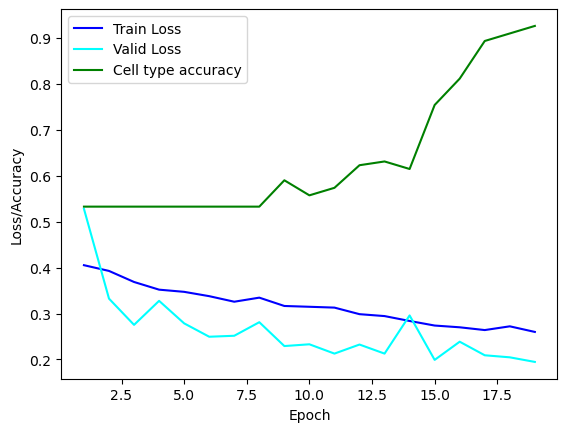

 Summary Train Loss: 0.2600, Valid Loss: 0.1947,Accuracy_Score: 92.02%,Cell Type Accuracy: 92.62%,Precision:71.38,IoU: 0.36,F1: 0.53


In [65]:
#wandb.login(key=")
os.environ["TORCH_USE_CUDA_DSA"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# Создание датасета и загрузчиков
ids = df['id'].unique()
from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(ids, test_size=0.2, random_state=CFG.seed)
train_loader, valid_loader = train_and_valid_dataloaders(df, train_ids, val_ids,resnet=True)

# Создание модели и обучение
#model = UNetWithCellType(dropout=True)
modelRN = UNetWithResNet(dropout=True)
train(modelRN,train_loader, valid_loader, CFG.num_epochs, CFG.lr)#,wandb=True)

# **Тестовый датасет и отриcовка результатов**

In [69]:
# Создание тестового датасета и загрузчиков

files = os.listdir(CFG.TEST_DIR)
image_ids = np.array([os.path.splitext(file)[0] for file in files])
ids = []
rle_test_preds = []
original_size = (704, 520)  

test_dataset = CellDataset(image_ids,df,CFG.TEST_DIR,transforms=DataTransforms.transform_valid(),status='test',resnet=True)

test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=CFG.train_batch_size,num_workers=CFG.num_workers,shuffle=True)

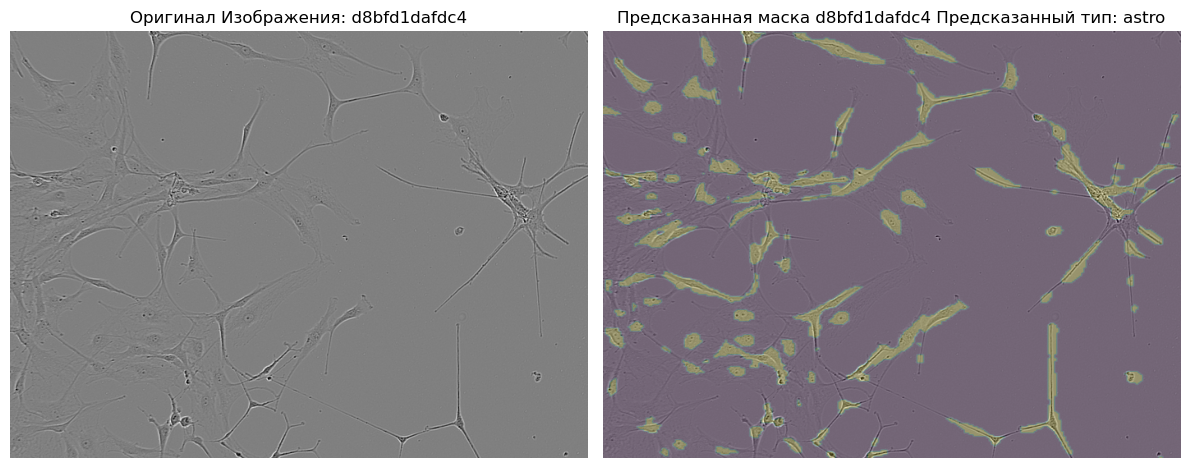

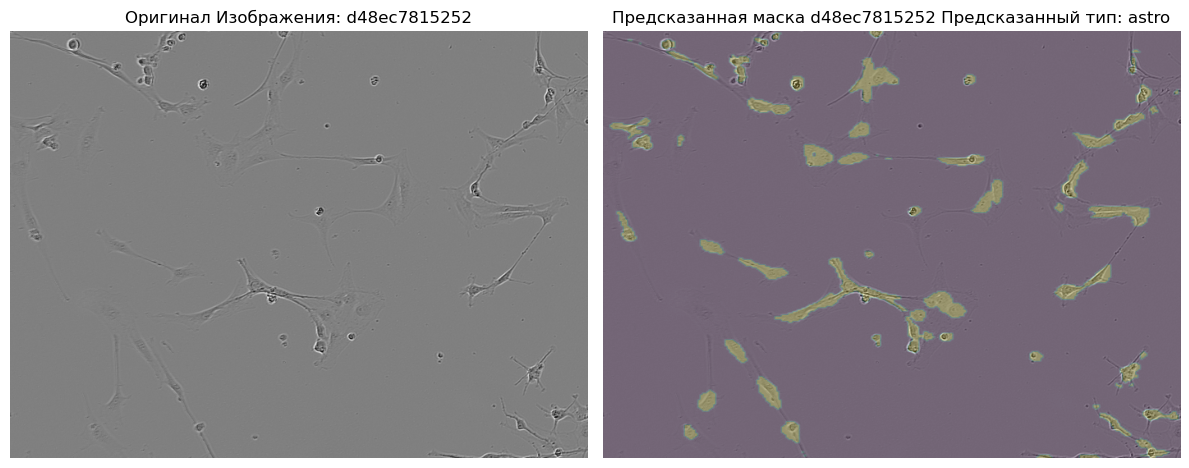

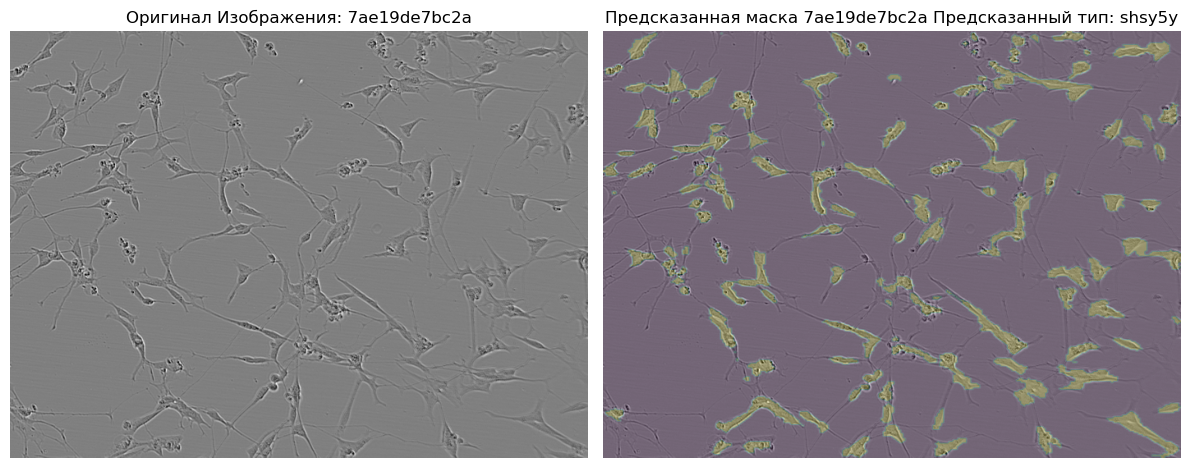

In [70]:
masks_list = test(modelRN, test_loader)

for i, (masks, image_ids, predicted_cell_type) in enumerate(masks_list):
    if masks.numel() == 0:  # Check if masks is empty
        continue
   
    # Преобразование масок в массивы NumPy
    masks = np.squeeze(masks) # Удаление размерности num_classes (если есть)
    masks = masks.cpu().numpy()  # Преобразование в массив NumPy
    full_masks = cv2.resize(masks, original_size)
    predicted_index = torch.argmax(predicted_cell_type, dim=-1)
    predicted_class = list(Cell_type_encoding.keys())[predicted_index.item()]
    
    # Отображение каждой маски
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread(CFG.TEST_DIR + image_ids + '.png'))
    plt.axis("off")
    plt.title(f'Оригинал Изображения: {image_ids}')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.imread(CFG.TEST_DIR + image_ids + '.png'))
    plt.imshow(full_masks, alpha=0.2)
    plt.title(f"Предсказанная маска {image_ids} Предсказанный тип: {predicted_class}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()